In [1]:
import os
import pickle

import scipy.io as sio
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.utils as tutils
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as tv_transforms
import torchvision.utils as vutils
import torchvision.datasets as tv_datasets
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda:0


# PCA with Cifar10

In [26]:
checkpoint = torch.load("data/cifar-100-python/res50_feas_resized.tar")
train_feature = checkpoint["x_train"]
test_feature = checkpoint["x_valid"]
print(train_feature.size())
print(test_feature.size())
print(checkpoint.keys())

torch.Size([50000, 2048])
torch.Size([10000, 2048])
dict_keys(['x_train', 'x_valid', 'y_train', 'y_valid'])


In [27]:
minmax_scaler = preprocessing.MinMaxScaler()
train_feature = minmax_scaler.fit_transform(train_feature)
test_feature = minmax_scaler.transform(test_feature)

scaler = preprocessing.StandardScaler()
train_feas = scaler.fit_transform(train_feature)
test_feas = scaler.transform(test_feature)

num_comp = 0.1
pca_fcn = PCA(num_comp).fit(train_feas)
train_pca = pca_fcn.transform(train_feas)
test_pca = pca_fcn.transform(test_feas)

inv_train = pca_fcn.inverse_transform(train_pca)
inv_test = pca_fcn.inverse_transform(test_pca)

In [28]:
torch.save({"train_x": inv_train,
            "test_x": inv_test,
            "test_y": checkpoint['y_valid'],
            "train_y": checkpoint['y_train']}, 
            f"data/cifar-100-python/pca{int(num_comp*2048)}.tar")

# Initialize Pre-trained Feature Extractor

In [ ]:
import torchvision.models as models

model = models.resnet101(pretrained=True)
model.fc = nn.Identity()
# model.maxpool = nn.Identity()
# model.avgpool = nn.Identity()
model = model.to(device)

In [ ]:
import torchvision.models as models
model = models.vgg16(pretrained=True)
# model.fc = nn.Identity()
# model.maxpool = nn.Identity()
# model.avgpool = nn.Identity()
model = model.to(device)

In [2]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained("efficientnet-b7")
model = model.to(device)

Loaded pretrained weights for efficientnet-b7


# One-Time Feature Extraction

For CIFAR10/100.

NOT Using Resnet56 from, https://github.com/akamaster/pytorch_resnet_cifar10

In [3]:
img_trans = tv_transforms.Compose([
#                                    tv_transforms.ToPILImage(),
                                   tv_transforms.Resize(224),
                                   tv_transforms.ToTensor(),
                                   tv_transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])


In [4]:
mb_size = 32
model.eval()
train_feas = []
train_labels = []
cifar100 = tv_datasets.CIFAR10("data", train=True, transform=img_trans, download=True)
dataloader = DataLoader(cifar100, batch_size=mb_size, num_workers=4)
with torch.no_grad():
    for x_mb, y_mb in dataloader:
#         feas_out = model(x_mb.to(device))
        feas_out = model._avg_pooling(model.extract_features(x_mb.to(device)))
        train_labels.append(y_mb.numpy())
        train_feas.append(feas_out.view(x_mb.size(0),-1).detach().cpu())

    train_feas = torch.cat(train_feas, dim=0)
    y_train = np.concatenate(train_labels)
    
test_feas = []
test_labels = []
cifar100 = tv_datasets.CIFAR10("data", train=False, transform=img_trans, download=True)
dataloader = DataLoader(cifar100, batch_size=mb_size, num_workers=4)
with torch.no_grad():
    for x_mb, y_mb in dataloader:
#         feas_out = model(x_mb.to(device))
        feas_out = model._avg_pooling(model.extract_features(x_mb.to(device)))
        test_labels.append(y_mb.numpy())
        test_feas.append(feas_out.view(x_mb.size(0),-1).detach().cpu())

    test_feas = torch.cat(test_feas, dim=0)
    y_valid = np.concatenate(test_labels)
    
print(f"train_feas: {train_feas.size()}")
print(f"train_labels: {y_train.shape}")
print(f"test_feas: {test_feas.size()}")
print(f"test_label: {y_valid.shape}")

Files already downloaded and verified
Files already downloaded and verified
train_feas: torch.Size([50000, 2560])
train_labels: (50000,)
test_feas: torch.Size([10000, 2560])
test_label: (10000,)


In [5]:
torch.save({"x_train": train_feas.cpu().detach(),
            "x_valid": test_feas.cpu().detach(),
            "y_train": torch.from_numpy(y_train).long(),
            "y_valid": torch.from_numpy(y_valid).long()}, 
#            "data/cifar-100-python/efficientb7_feas_resized.tar")
           "data/cifar-10-batches-py/efficientb7_feas_resized.tar")

# Feature Extraction for ImageNet

In [2]:
import glob
import torchvision.models as models
import albumentations as transforms
from albumentations.pytorch import ToTensorV2
from pipeline.imagenet_dataset import TrainDataset

model = models.resnet18()
model.load_state_dict(torch.load("best.pth")["model"])
model.fc = nn.Identity()
model = model.to(device)

In [3]:
DATADIR = os.path.expanduser("~/project/data/ILSVR2012/")
train_data_path = os.path.join(DATADIR,"train")
val_data_path = os.path.join(DATADIR,"val")

# Select the first 500
class_lst = glob.glob(os.path.join(train_data_path,'*'))[:100]
label_map = {key.split("/")[-1]: idx for idx, key in enumerate(class_lst)}

train_img_path = [glob.glob(f"{apth}/*.JPEG") for apth in class_lst]
train_img_path = [img for apth in train_img_path for img in apth]

valid_img_path = []

for each_key in label_map.keys():
    val_path = os.path.join(val_data_path, each_key)
    valid_img_path.append(glob.glob(f"{val_path}/*.JPEG"))
valid_img_path = [img for apth in valid_img_path for img in apth]

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1.0, max_pixel_value=255.0,
)

valid_transform = transforms.Compose([transforms.Resize(224, 224), normalize, ToTensorV2()], p=1.0)

train_ds = TrainDataset(train_img_path, label_map, transform=valid_transform)
valid_ds = TrainDataset(valid_img_path, label_map, transform=valid_transform)

train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
)
valid_loader = DataLoader(
    valid_ds,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last=False,
)


In [4]:
model.eval()
train_feas = []
train_labels = []
for idx, (x_mb, y_mb) in enumerate(train_loader):
    x_mb = x_mb.to(device)
    feas = model(x_mb)
    train_feas.append(feas.detach().cpu())
    train_labels.append(y_mb)
    
train_feas = torch.cat(train_feas, dim=0)
train_labels = torch.cat(train_labels, dim=0)
print(f"feas size - {train_feas.shape}")
print(f"label size - {train_labels.shape}")
print(f"unique - {np.unique(train_labels.numpy()).shape[0]}")

feas size - torch.Size([128320, 512])
label size - torch.Size([128320])
unique - 100


In [5]:
valid_feas = []
valid_labels = []
for idx, (x_mb, y_mb) in enumerate(valid_loader):
    x_mb = x_mb.to(device)
    feas = model(x_mb)
    valid_feas.append(feas.detach().cpu())
    valid_labels.append(y_mb)
    
valid_feas = torch.cat(valid_feas, dim=0)
valid_labels = torch.cat(valid_labels, dim=0)
print(f"feas size - {valid_feas.shape}")
print(f"label size - {valid_labels.shape}")
print(f"unique - {np.unique(valid_labels.numpy()).shape[0]}")

feas size - torch.Size([5000, 512])
label size - torch.Size([5000])
unique - 100


In [6]:
torch.save({"x_train": train_feas.cpu().detach(),
            "x_valid": valid_feas.cpu().detach(),
            "y_train": train_labels.long(),
            "y_valid": valid_labels.long()}, 
           "data/resnet18_imagenet100_feas.tar")

# Load Extracted Features

In [ ]:
checkpoint = torch.load("data/cifar-10-batches-py/res50_feas_resized.tar")
# checkpoint = torch.load("data/cifar-100-python/res50_feas_resized.tar")
x_train = checkpoint["x_train"].numpy()
x_valid = checkpoint["x_valid"].numpy()

y_train = checkpoint['y_train']
y_valid = checkpoint["y_valid"]

scaler = preprocessing.MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)
x_train = torch.from_numpy(x_train)
x_valid = torch.from_numpy(x_valid)

In [ ]:
mask0 = y_train >= 8
mask1 = y_train < 10
mask = mask0 * mask1
task_train_x = x_train[mask]
task_train_y = y_train[mask]

mask0 = y_valid >= 0
mask1 = y_valid < 10
mask = mask0 * mask1
task_test_x = x_valid[mask]
task_test_y = y_valid[mask]

In [ ]:
from gen_model import LinearCLS

mb_size = 128
linear_cls = LinearCLS(x_train.size(1), 10).to(device)
optimizer_cls = torch.optim.Adam(linear_cls.parameters(), lr=0.001, betas=(0.5, 0.999))
cls_criterion = nn.NLLLoss()


# Train Upper Bound Classifier

In [21]:
from models.gen_model import LinearCLS

mb_size = 128
linear_cls = LinearCLS(train_feas.size(1), 50).to(device)
optimizer_cls = torch.optim.Adam(linear_cls.parameters(), lr=0.001, betas=(0.5, 0.999))
cls_criterion = nn.NLLLoss()

num_iter = train_feas.size(0) // mb_size
bd_indices = [ii for ii in range(0, train_labels.size(0), mb_size)]

for epc in range(40):
    batch_indices = np.random.permutation(np.arange(train_feas.size(0)))
    for idx, iter_count in enumerate(bd_indices):
        batch_idx = batch_indices[iter_count:iter_count+mb_size]
        x_mb = train_feas[batch_idx].float().to(device)
        y_mb = train_labels[batch_idx].to(device)
        output = linear_cls(x_mb)
        loss = cls_criterion(output, y_mb)
        optimizer_cls.zero_grad()
        loss.backward()
        optimizer_cls.step()


In [ ]:
mb_size = 128
num_iter = task_train_x.size(0) // mb_size
bd_indices = [ii for ii in range(0, task_train_x.size(0), mb_size)]

for epc in range(40):
    batch_indices = np.random.permutation(np.arange(task_train_x.size(0)))
    for idx, iter_count in enumerate(bd_indices):
        batch_idx = batch_indices[iter_count:iter_count+mb_size]
        x_mb = task_train_x[batch_idx].float().to(device)
        y_mb = task_train_y[batch_idx].to(device)
        output = linear_cls(x_mb)
        loss = cls_criterion(output, y_mb)
        optimizer_cls.zero_grad()
        loss.backward()
        optimizer_cls.step()

        
num_iter = task_test_x.size(0) // mb_size
bd_indices = [ii for ii in range(0, task_test_x.size(0), mb_size)]
batch_indices = np.arange(task_test_x.size(0))
corr = 0
with torch.no_grad():
    for idx, iter_count in enumerate(bd_indices):
        batch_idx = batch_indices[iter_count:iter_count+mb_size]
        x_mb = task_test_x[batch_idx].float().to(device)
        y_mb = task_test_y[batch_idx].to(device)
        output = linear_cls(x_mb)
        pred = torch.argmax(output,dim=1)
        corr += torch.sum(torch.eq(y_mb, pred))

acc = 100*corr / float(task_test_x.size(0))
print(f"accuracy: {acc}")

In [23]:
num_iter = valid_feas.size(0) // mb_size
bd_indices = [ii for ii in range(0, valid_feas.size(0), mb_size)]
batch_indices = np.arange(valid_feas.size(0))
corr = 0
with torch.no_grad():
    for idx, iter_count in enumerate(bd_indices):
        batch_idx = batch_indices[iter_count:iter_count+mb_size]
        x_mb = valid_feas[batch_idx].float().to(device)
        y_mb = valid_labels[batch_idx].to(device)
        output = linear_cls(x_mb)
        pred = torch.argmax(output,dim=1)
        corr += torch.sum(torch.eq(y_mb, pred))

acc = 100*corr / float(valid_feas.size(0))
print(f"accuracy: {acc}")

accuracy: 92.36000061035156


# Visualization

In [9]:
comp_percent = np.arange(1,10)*0.1
res_lst = []
for acount in comp_percent:
    pca_acc = []
    for idx in range(1,6):
        pca_res = np.genfromtxt(f"out/split-cifar100/supp/pca{int(2048*acount)}-nepoch-70/lin_acc_it0{idx}.txt", delimiter=",")
        pca_acc.append(np.mean(pca_res[-1])*0.01)
    res_lst.append(pca_acc)
    
pca_acc = []
for idx in range(1,6):
    pca_res = np.genfromtxt(f"out/split-cifar100/res50_feas_resized-nepoch70-nSample300-A5/cl_acc_it0{idx}.txt", delimiter=",")
    pca_acc.append(np.mean(pca_res[-1])*0.01)
res_lst.append(pca_acc)

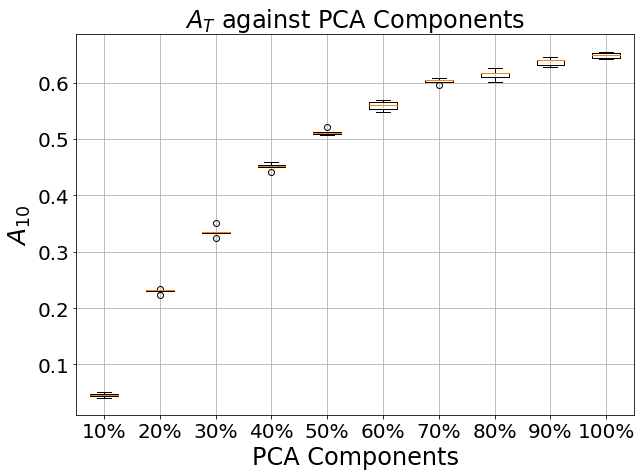

In [15]:
pca_count = [f"{idx*10}%" for idx in range(1,11)]
plt.figure(figsize=(10,7))
plt.boxplot(res_lst)

plt.xticks(np.arange(1,11), labels=pca_count, fontsize=20)
plt.xlabel("PCA Components", fontsize=24)
plt.ylabel(r"$A_{10}$", fontsize=25)
plt.yticks(fontsize=20)
plt.title(r"$A_T$ against PCA Components", fontsize=24)
plt.grid(True)
# plt.show()
plt.savefig("pca-cifar100.png",bbox_inches='tight')

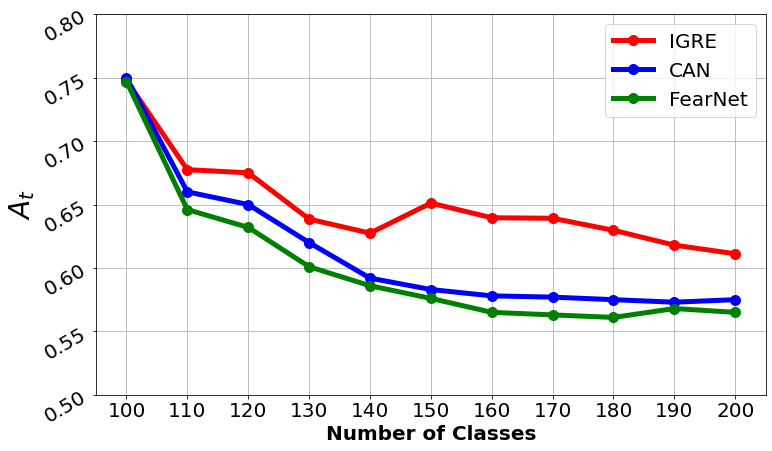

In [11]:
# from matplotlib import rc
# rc('font', weight='bold')

pca_res = np.genfromtxt(f"out/split-cub/res101-nepoch30-nSample300-A10/cl_acc_it02.txt", delimiter=",")

mask = pca_res == 0
pca_res[mask] = np.nan
arr = np.nanmean(pca_res, axis=1) / 100.

can_res = [0.75, 0.66, 0.65, 0.62, 0.592, 0.583, 0.578, 0.577, 0.575, 0.573, 0.575]
fearnet_res = [0.747, 0.646, 0.632, 0.601, 0.586, 0.576, 0.565, 0.563, 0.561, 0.568, 0.565]
icarl_res = [695, 65.3, 62.4, 60.4, 59.5]
# for idx in range(1,6):
#     pca_res = np.genfromtxt(f"out/cifar100-res50-300/cl_acc_it0{idx}.txt", delimiter=",")
#     pca_acc.append(np.mean(pca_res[-1]))
# res_lst.append(pca_acc)

tick_lab = [ii for ii in range(100, 205, 10)]
plt.figure(figsize=(12,7))
plt.plot(arr[:], "-ro", label="IGRE", linewidth=5, markersize=10)
plt.plot(can_res, "-bo", label="CAN", linewidth=5, markersize=10)
plt.plot(fearnet_res, "-go", label="FearNet", linewidth=5, markersize=10)
# plt.plot(icarl_res, "-go", label="iCARL")
# plt.xlabel(r"Task, $t$", fontsize=20)
plt.xlabel("Number of Classes", fontsize=20, fontweight='bold')
plt.xticks(np.arange(arr[:].shape[0]), labels=tick_lab, fontsize=20)
plt.ylabel(r"$A_t$", fontsize=28)
yticks = np.arange(0.5, 0.8, 0.05)
ylab =[f"{ii:.2f}" for ii in np.arange(0.5, 0.8, 0.05)]
plt.yticks(yticks, labels=ylab, fontsize=20, rotation=30)
plt.grid(True)
plt.legend(fontsize=20)
# plt.show()
plt.savefig("cub-prog-2.png", bbox_inches="tight")